In [1]:
"""A script showing how to DIARIZATION ON WAV USING UIS-RNN."""

'A script showing how to DIARIZATION ON WAV USING UIS-RNN.'

In [2]:
import numpy as np
import uisrnn
import librosa
import sys
sys.path.append('ghostvlad')
sys.path.append('visualization')
import toolkits
import model as spkModel
import os
from viewer import PlotDiar
import json

Using TensorFlow backend.


In [3]:
# global variable
wav_filename = 'wavs/Maya.wav'
SAVED_MODEL_NAME = 'pretrained/saved_model.uisrnn_benchmark'

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
global args
# net choices=['resnet34s', 'resnet34l']
# aggregation_mode choices=['avg', 'vlad', 'gvlad']
# loss choices=['softmax', 'amsoftmax']
# test_type  choices=['normal', 'hard', 'extend']
args = Namespace( gpu='', resume=r'ghostvlad/pretrained/weights.h5', 
                  data_path='4persons', net='resnet34s', ghost_cluster=2,
                  vlad_cluster=8, bottleneck_dim=512, aggregation_mode='gvlad',
                  loss='softmax', test_type='normal')

In [4]:
def genMap(intervals):
    ''' This function generate dictionary mapping from key frame and its interval
            for each speech interval
    '''
    
    # calculate interval for each slice
    slicelen = [sliced[1]-sliced[0] for sliced in intervals.tolist()]
    
    # generate map table
    mapTable = {}  
    idx = 0
    for i, sliced in enumerate(intervals.tolist()):
        mapTable[idx] = sliced[0]
        idx += slicelen[i]
    mapTable[sum(slicelen)] = intervals[-1,-1]

    # extract key(start) frame of each interval
    keys = [k for k,_ in mapTable.items()]
    keys.sort()
    return mapTable, keys

In [5]:
def append2dict(speakerSlice, spk_period):
    ''' This helper function append spekaer period to the dict
    '''
    key = list(spk_period.keys())[0]
    value = list(spk_period.values())[0]
    timeDict = {}
    timeDict['start'] = int(value[0]+0.5)
    timeDict['stop'] = int(value[1]+0.5)
    if(key in speakerSlice):
        speakerSlice[key].append(timeDict)
    else:
        speakerSlice[key] = [timeDict]

    return speakerSlice

In [6]:
def arrangeResult(labels, time_spec_rate): 
    ''' This function arrance result of diarization to a dictionary
        It maps speakerId to the list of interval information as example below
        {'1': [{'start':10, 'stop':20}, {'start':30, 'stop':40}], '2': [{'start':90, 'stop':100}]}
    '''
    # get the first label, make it the last label to be considered
    lastLabel = labels[0]
    
    # create empty output dictionary
    speakerSlice = {}
    
    # for each loop, try to find the longest appearence of the label,
    #   then, compute the time for that speech segment
    j = 0
    for i,label in enumerate(labels):
        if(label==lastLabel):
            continue
        speakerSlice = append2dict(speakerSlice, {lastLabel: (time_spec_rate*j,time_spec_rate*i)})
        j = i
        lastLabel = label
    speakerSlice = append2dict(speakerSlice, {lastLabel: (time_spec_rate*j,time_spec_rate*(len(labels)))})
    
    # return dict
    return speakerSlice

In [7]:
# 0s        1s        2s                  4s                  6s
# |-------------------|-------------------|-------------------|
# |-------------------|
#           |-------------------|
#                     |-------------------|
#                               |-------------------|
def load_data(path, win_length=400, sr=16000, hop_length=160, n_fft=512, embedding_per_second=0.5, overlap_rate=0.5):
    ''' This function reads wav file, and then create spectogram from the audio, finding the magnitude, frequency
        Then, apply the sliding window to create spectogram information for each utterance
    '''
    
    # read wav file
    wav, intervals = load_wav(path, sr=sr)
    
    # create spectogram
    linear_spect = lin_spectogram_from_wav(wav, hop_length, win_length, n_fft)
    
    # get magnitude of the spectograme
    mag, _ = librosa.magphase(linear_spect)
    
    # get transpose of the magnitude numpy array
    # we can get frequency, time
    mag_T = mag.T
    freq, time = mag_T.shape
    spec_mag = mag_T

    # calculate len of spectogram
    spec_len = sr/hop_length/embedding_per_second
    spec_hop_len = spec_len*(1-overlap_rate)

    # prepare sliding window
    cur_slide = 0.0
    utterances_spec = []

    # loop for each sliding window
    while(True):
        if(cur_slide + spec_len > time):
            break
            
        # get spectogram magnitude of this sliding windiw
        spec_mag = mag_T[:, int(cur_slide+0.5) : int(cur_slide+spec_len+0.5)]
        
        # preprocessing, subtract mean, divided by time-wise var
        mu = np.mean(spec_mag, 0, keepdims=True)
        std = np.std(spec_mag, 0, keepdims=True)
        spec_mag = (spec_mag - mu) / (std + 1e-5)
        
        # store in teh uterance spectograme list
        utterances_spec.append(spec_mag)

        cur_slide += spec_hop_len

    return utterances_spec, intervals


In [8]:
def load_wav(vid_path, sr):
    ''' This function loads wav file and convert to np array
    '''
    wav, _ = librosa.load(vid_path, sr=sr)
    intervals = librosa.effects.split(wav, top_db=20)
    wav_output = []
    for sliced in intervals:
        wav_output.extend(wav[sliced[0]:sliced[1]])
    return np.array(wav_output), (intervals/sr*1000).astype(int)

In [9]:
def lin_spectogram_from_wav(wav, hop_length, win_length, n_fft=1024):
    ''' This function get linear spectogram from wav file
    '''
    linear = librosa.stft(wav, n_fft=n_fft, win_length=win_length, hop_length=hop_length)
    return linear.T

In [10]:
def fmtTime(timeInMillisecond):
    '''This helper functions convery time in millisecond to time string
    '''
    millisecond = timeInMillisecond%1000
    minute = timeInMillisecond//1000//60
    second = (timeInMillisecond-minute*60*1000)//1000
    time = '{}:{:02d}.{}'.format(minute, second, millisecond)
    return time


In [11]:
def main(wav_path, embedding_per_second=1.0, overlap_rate=0.5):
    ''' This is the main function for do diarization using uis-rnn
        The final result is influenced by the size of each window and the overlap rate.
        When the overlap is too large, the uis-rnn perhaps generates fewer speakers 
            since the speaker embeddings changed smoothly, otherwise will generate more 
            speakers.
        And also, the window size cannot be too short, it must contain enough information 
            to generate more discrimitive speaker embeddings.
    '''

    # gpu configuration
    # if use gpu, specify device number 
    # otherswise, leave it blank
    toolkits.initialize_GPU(args)

    # parameters for uis-rnn
    params = {'dim': (257, None, 1),
              'nfft': 512,
              'spec_len': 250,
              'win_length': 400,
              'hop_length': 160,
              'n_classes': 5994,
              'sampling_rate': 16000,
              'normalize': True,
              }

    # create network and load weight
    # this is for VGG-Speaker-recognition
    network_eval = spkModel.vggvox_resnet2d_icassp(input_dim=params['dim'],
                                                num_class=params['n_classes'],
                                                mode='eval', args=args)
    network_eval.load_weights(args.resume, by_name=True)
    
    # get model arguments for uis-rnn for speaker diarization
    model_args, _, inference_args = uisrnn.parse_arguments()
    model_args.observation_dim = 512
    uisrnnModel = uisrnn.UISRNN(model_args)
    uisrnnModel.load(SAVED_MODEL_NAME)

    # load data and create spectogram
    # specs: vector of spectogram
    # intervals: frame period of the vector
    specs, intervals = load_data(wav_path, embedding_per_second=embedding_per_second, overlap_rate=overlap_rate)
    
    # create dictionary for the previous information
    # mapTable is the dictionary that map start frame to its interval
    # keys is the list of the key in previous dictionary
    mapTable, keys = genMap(intervals)

    # create feature vector for each interval
    feats = []
    for spec in specs:
        spec = np.expand_dims(np.expand_dims(spec, 0), -1)
        v = network_eval.predict(spec)
        feats += [v]

    # feec feature vector to predict speaker for each interval
    feats = np.array(feats)[:,0,:].astype(float)  # [splits, embedding dim]
    predicted_label = uisrnnModel.predict(feats, inference_args)
    
    # arrange result to make the structure for speaker id, start, stop for each interval
    time_spec_rate = 1000*(1.0/embedding_per_second)*(1.0-overlap_rate) # speaker embedding every ?ms
    center_duration = int(1000*(1.0/embedding_per_second)//2)
    speakerSlice = arrangeResult(predicted_label, time_spec_rate) # need to fix this to create json output

    # create result dictionary
    for spk,timeDicts in speakerSlice.items():    # time map to orgin wav(contains mute)
        for tid,timeDict in enumerate(timeDicts):
            s = 0
            e = 0
            for i,key in enumerate(keys):
                if(s!=0 and e!=0):
                    break
                if(s==0 and key>timeDict['start']):
                    offset = timeDict['start'] - keys[i-1]
                    s = mapTable[keys[i-1]] + offset
                if(e==0 and key>timeDict['stop']):
                    offset = timeDict['stop'] - keys[i-1]
                    e = mapTable[keys[i-1]] + offset

            speakerSlice[spk][tid]['start'] = s
            speakerSlice[spk][tid]['stop'] = e

    # print out the result from the result dictionary
    jsonDict = {}
    for spk,timeDicts in speakerSlice.items():
        print('========= Speaker ' + str(spk) + ' =========')
        jsonDict['Speaker {}'.format(spk)] = []
        for timeDict in timeDicts:
            s = timeDict['start']
            e = timeDict['stop']
            s = fmtTime(s)  # change point moves to the center of the slice
            e = fmtTime(e)
            print(s+' ==> '+e)
            jsonDict['Speaker {}'.format(spk)].append({'start':s, 'stop':e})
    
    with open('result.json', 'w') as fp:
        json.dump(jsonDict, fp)

    # plot the result of diarization on timeline
    %matplotlib notebook
    p = PlotDiar(map=speakerSlice, wav=wav_path, gui=True, size=(25, 6))
    p.draw()
    p.plot.show()



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


========= Speaker 0 =========
0:01.696 ==> 0:03.952
0:06.380 ==> 0:09.360
0:10.872 ==> 0:22.236
0:28.400 ==> 0:35.402
0:39.446 ==> 0:42.650
========= Speaker 1 =========
0:03.952 ==> 0:06.380
0:09.360 ==> 0:10.872
0:22.236 ==> 0:28.400
0:35.402 ==> 0:39.446
0:42.650 ==> 0:44.790


<IPython.core.display.Javascript object>


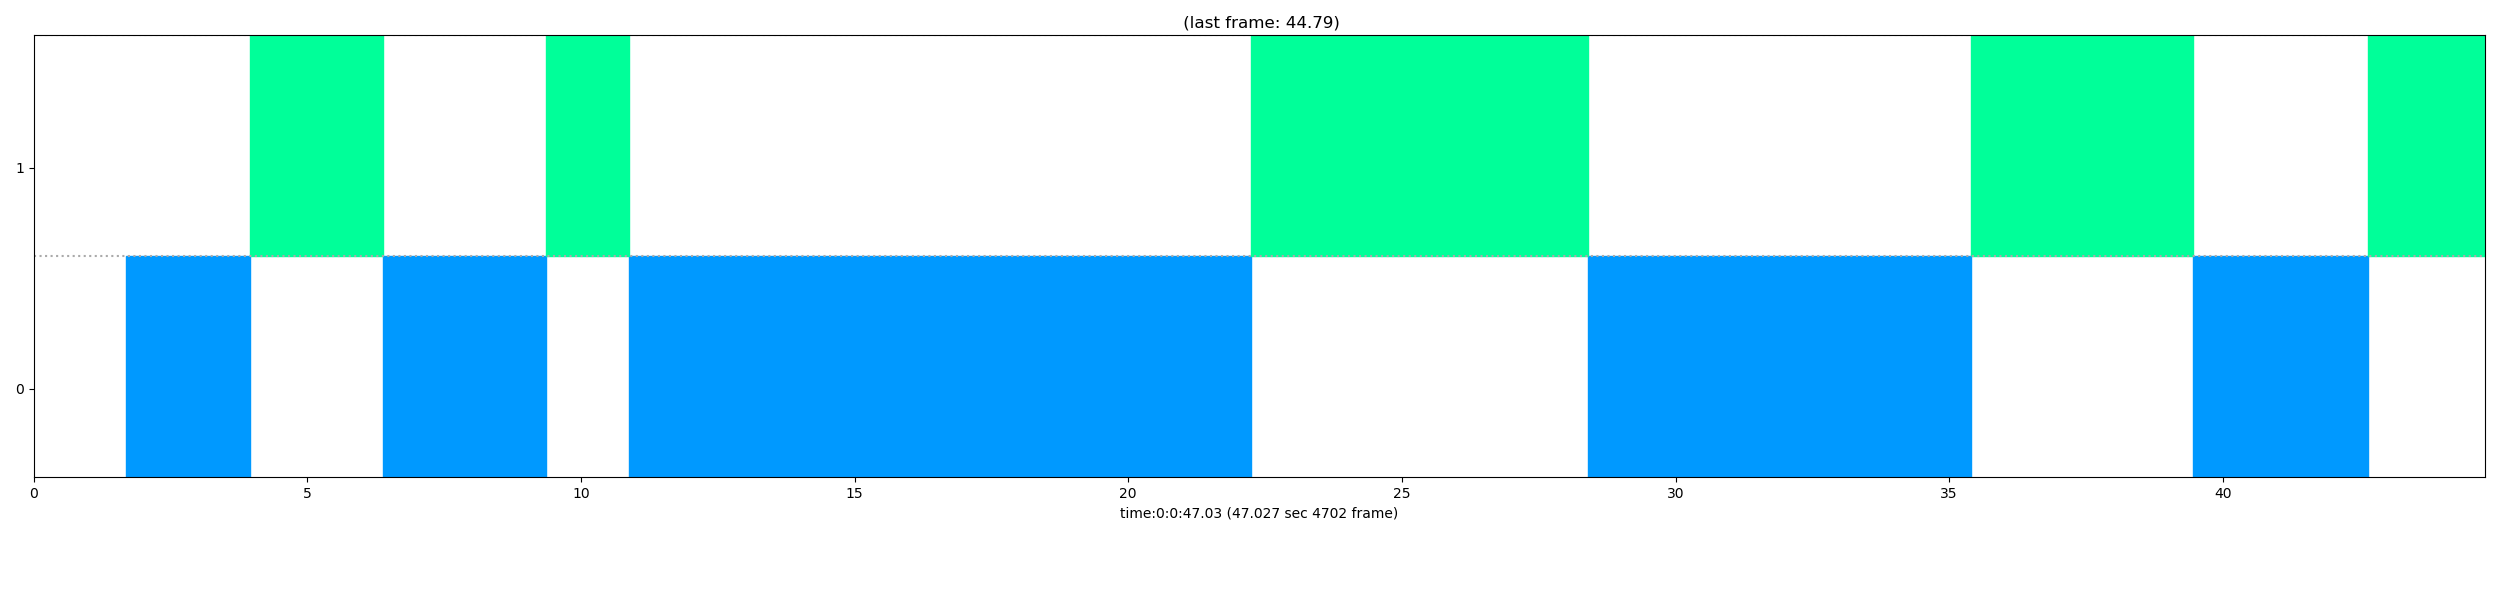

In [12]:
# how to call
main(wav_filename, embedding_per_second=1.2, overlap_rate=0.4)